# Second Visualzation: Digging deeper into the most up-to-date NYC citi bike data.
### This bird's-eye view was put together in Adobe Illustrator, zoom-in if it looks too small in the cell, or scroll down to see each individual experiments. 

In [94]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url='https://i.imgur.com/44JDaMS.jpg')

# TL; DR 

## Dataset
#### Most recent 2019 NYC citibike trip data(over 3 millions records)

## What's in here?
#### Some data driven arguments and statements, **interactive map visualization**.

## Conclusion
    Scroll down to see interactive maps, pop-up texts will be shown on clicking.
#### 1. Broad way and its intersections are very popular starting point, appearing 6 times out of the 25 most crowded starting stations.
    - Most crowded returning stations almost coincide with starting stations, except for bikes from E 13 St & Avenue A tend to be returned to 1 Ave & E 16 St.
#### 2. The most popular place for a "Joy Ride" is Central Park South.
    - And joy riders are most likely to be those male subscribers.
#### 3. Identifying stations that have non-zero net departure and arrival.
      - Columbus Ave & W 72 St station has the largest net departure, first 3 months in 2019, 2306 bikes left the station more than bikes coming.
      - DeKalb Ave & Hudson Ave station has the largest net arrival, first 3 months in 2019, 2683 bikes came to the station more than leaving.
#### 4. Net departure by time, analyzing the demand change in weekday on 8AM (go to work) and 6PM (off work).
      - Daylight Saving Time effect is correctly handled!
      - In 8AM, people went into the center of the city, and in 6PM people returned from where they headed in the morning.
#### 5. Identifying anomalies in trip duration, very long duration may suggest for example a bike repairing event. 
      - A trip from SF historical data shown, on 2014-12-06 a trip has a duration of nearly 200 days leaving South Van Ness at Market. So must be an error.
      - NYC data, a trip on 2019-03-30 leaving Monroe St & Bedford Ave for 9.5 days, and re-parked at Macon St & Nostrand Ave. It could be a bike repair.|

## Future Work Proposal(More time will be needed)
1. Create heatmap to show traffic of regions. 
2. Use glow effect to show the traffic of individual street/avenue.
3. Add interactive layers to the map to adopt user-inputed filters.
4. Receving and displaying real-time data feed (Ultimate Goal).

--- 
> Below are all the code that generated above results

In [1]:
import os
from os import path
import modin.pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

import folium

Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-05-05_20-34-14_47353/logs.
Waiting for redis server at 127.0.0.1:17506 to respond...
Waiting for redis server at 127.0.0.1:65112 to respond...
Starting Redis shard with 10.0 GB max memory.
Starting the Plasma object store with 10.0 GB memory using /tmp.


In [2]:
# Figure style
sns.set(style='ticks', font_scale=1.3,
        rc={'font.family': 'M+ 1mn', 
            'axes.labelsize': 17, 'axes.titlesize': 21, 'xtick.labelsize': 15, 'ytick.labelsize': 15})

# Integer axis tick
from matplotlib.ticker import MaxNLocator


# Percent axis tick label
from matplotlib.ticker import FuncFormatter
def to_percent(y, position):
    """ Create the formatter using the function to_percent. This multiplies all the
            default labels by 100, making them all percentages.
        Ignore the passed in position. This has the effect of scaling the default
            tick locations.
        Usage: Set the formatter: axes.yaxis.set_major_formatter(formatter)

""" 
    s = f'{100 * y:.0f}'
    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'
to_perc = FuncFormatter(to_percent)

def append_k(y, position):
    return f'{y:.0f}K'
in_k = FuncFormatter(append_k)
def append_perc(y, position):
    return f'{y:.0f}%'
append_perc = FuncFormatter(append_perc)

In [3]:
path_sf = 'sf-bay-area-bike-share/'
path_la = 'los-angeles-metro-bike-share-trip-data/'

In [4]:
station = pd.read_csv(path.join(path_sf, 'station.csv'))
status = pd.read_csv(path.join(path_sf, 'status.csv'))
trip = pd.read_csv(path.join(path_sf, 'trip.csv'))
weather = pd.read_csv(path.join(path_sf, 'weather.csv'), parse_dates=['date'])

In [5]:
bike_la = pd.read_csv(path.join(path_la, 'metro-bike-share-trip-data.csv'))
bike_la.columns = bike_la.columns.map(lambda x: x.lower().replace(' ', '_'))

In [65]:
# trip['start_date'] = pd.to_datetime(trip['start_date'])
# trip['end_date'] = pd.to_datetime(trip['end_date'])
# trip['dayofweek'] = trip['start_date'].dt.weekday

bike_la['start_time'] = pd.to_datetime(bike_la['start_time'])
bike_la['dayofweek'] = bike_la['start_time'].dt.weekday

In [66]:
def nyc_bikedata(years, months):
    container = []
    for year in years:
        for month in months:
            fn = path.join('NYC-citibike/', f'{year}{month:02d}-citibike-tripdata.csv')
            print('loading', fn)
            if path.isfile(fn):
                container.append(pd.read_csv(fn, parse_dates=['starttime', 'stoptime']))
    df = pd.concat(container, axis=0)
    return df

nyc = nyc_bikedata([2019], [1, 2, 3])
nyc.columns = nyc.columns.map(lambda x: x.replace(' ', '_'))

loading NYC-citibike/201901-citibike-tripdata.csv
loading NYC-citibike/201902-citibike-tripdata.csv
loading NYC-citibike/201903-citibike-tripdata.csv


In [67]:
print('----- shape of data San Francisco-----')
print(f'Station: {station.shape}')
print(f'status: {status.shape}')
print(f'trip: {trip.shape}')
print(f'weather: {weather.shape}')
print('----- shape of data Los Angeles-----')
print(f'bike_la: {bike_la.shape}')
print('----- shape of data NYC -----')
print(f'NYC trip data {nyc.shape}')

----- shape of data San Francisco-----
Station: (70, 7)
status: (71984434, 4)
trip: (669959, 12)
weather: (3665, 24)
----- shape of data Los Angeles-----
bike_la: (132427, 17)
----- shape of data NYC -----
NYC trip data (3238991, 15)


# 25 Most crowded starting and returning station

In [68]:
def hot_depart(df, n):
    count = df.groupby('start_station_id').size().sort_values(ascending=False).iloc[:n]
    count.name = 'departure_count'
    info = df[df['start_station_id'].isin(count.index)].groupby('start_station_id').first()[['start_station_name', 'start_station_latitude', 'start_station_longitude']]
    return pd.concat([count, info], axis=1)
# top 25 starting station
depart_25 = hot_depart(nyc, 25)
# top 25 arrival station
acount = nyc.groupby('end_station_id').size().sort_values(ascending=False).iloc[:25]
acount.name = 'arrival_count'
ainfo = nyc[nyc['end_station_id'].isin(acount.index)].groupby('end_station_id').first()[['end_station_name', 'end_station_latitude', 'end_station_longitude']]
arrival_25 = pd.concat([acount, ainfo], axis=1)

In [69]:
center=depart_25.filter(like='tude').mean().values.tolist()
folium_map = folium.Map(location=center, zoom_start=14, tiles='CartoDB dark_matter', width = '65%')
for idx, row in depart_25.iterrows():
    popup_text = f"{row['start_station_name']}<br> total departures: {row['departure_count']}<br>"
    radius = row['departure_count'] / 1000
    folium.CircleMarker(location=(row['start_station_latitude'], row['start_station_longitude']),
                        radius=radius, color='#E37222',popup=popup_text, fill=True).add_to(folium_map)
# for idx, row in arrival_25.iterrows():
#     popup_text = f"{row['end_station_name']}<br> total arrivals: {row['arrival_count']}<br>"
#     radius = row['arrival_count'] / 1000
#     folium.CircleMarker(location=(row['end_station_latitude'], row['end_station_longitude']),
#                         radius=radius, color='#0A8A9F',popup=popup_text, fill=True).add_to(folium_map)

#### Uncomment the above to show the returning stations, however they will be overlapped except for bikes from E 13 St & Avenue A tend to be returned to 1 Ave & E 16 St.

In [70]:
depart_25.head(10)

,departure_count,start_station_name,start_station_latitude,start_station_longitude
285.0,18098,Broadway & E 14 St,40.734546,-73.990741
293.0,15550,Lafayette St & E 8 St,40.730207,-73.991026
358.0,13349,Christopher St & Greenwich St,40.732916,-74.007114
359.0,15824,E 47 St & Park Ave,40.755103,-73.974987
379.0,14984,W 31 St & 7 Ave,40.749156,-73.991600
402.0,19696,Broadway & E 22 St,40.740343,-73.989551
435.0,21044,W 21 St & 6 Ave,40.741740,-73.994156
459.0,15301,W 20 St & 11 Ave,40.746745,-74.007756
465.0,14343,Broadway & W 41 St,40.755136,-73.986580
468.0,13634,Broadway & W 56 St,40.765265,-73.981923


In [72]:
folium_map

# Joy rides around Central Park! 
  - The most popular place for joy rides is Central Park.
  - People who take a joy rides are relatively more likely to be a male subsriber and a female customer.
  - Only 1.6% rides are joy rides, so clearly customer used the bike to travel instead of for fun.
  
I defined the joy rides as the ride that start and end at the same station, which means the rider took the bike for a "joy ride" and then returned it instead of commute to somewhere.
Joy rides only count for rides that last longer than 2 minutes to remove potentially false starts or staff/users trying to re-dock a bike to ensure it's secure.

In [73]:
def ride_perc_gender_usertype(df):
    x = df.groupby(['gender', 'usertype']).size()
    x2 = x.reset_index()
    x2.columns = ['gender', 'usertype', 'count']
    perc = x / np.repeat(x2.groupby('gender')['count'].sum().values, 2)
    return perc.values
    

In [74]:
joy = nyc.query('tripduration > 120 & start_station_id == end_station_id')
joy_y = ride_perc_gender_usertype(joy)

In [75]:
normal = nyc.query('tripduration > 120 & start_station_id != end_station_id')
normal_y = ride_perc_gender_usertype(normal)

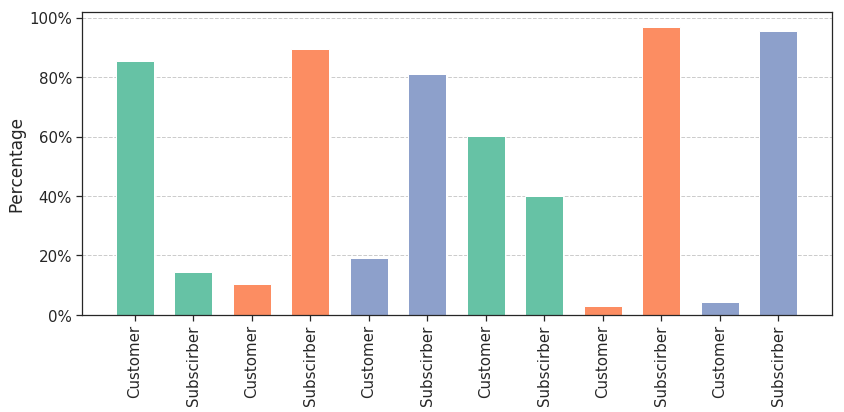

In [77]:
fig, ax = plt.subplots(figsize=(12, 6))
width=.65
_col = np.repeat(sns.color_palette('Set2')[:3], 2, axis=0)
_cols = np.r_[_col, _col]
ax.bar(range(12), np.r_[joy_y, normal_y], color=_cols, width=width)
ax.yaxis.set_major_formatter(to_perc)
ax.grid(which='major', axis='y', linestyle='--')
ax.set_xticks(range(12))
ax.set_xticklabels(np.tile(['Customer', 'Subscirber'], 6), rotation=90)
ax.set_ylabel('Percentage')

fig.tight_layout()
fig.savefig(path.join('img', 'joy-rides.pdf'))

## Joy ride station

In [78]:
def hot_depart(df, n):
    count = df.groupby('start_station_id').size().sort_values(ascending=False).iloc[:n]
    count.name = 'count'
    info = df[df['start_station_id'].isin(count.index)].groupby('start_station_id').first()[['start_station_name', 'start_station_latitude', 'start_station_longitude']]
    df = pd.concat([count, info], axis=1)
    df.columns = ['count', 'station_name', 'latitude', 'longitude']
    return df

def plot_station(df, **kwargs):
    center=df.filter(like='tude').mean().values.tolist()
    folium_map = folium.Map(location=center, zoom_start=kwargs['zoom_start'], tiles='CartoDB dark_matter', width = '65%')
    for idx, row in df.iterrows():
        popup_text = f"{row['station_name']}<br> total {kwargs['poptxt_label']}: {row['count']}<br>"
        radius = row['count'] / kwargs['rad_scale']
        folium.CircleMarker(location=(row['latitude'], row['longitude']),
                            radius=radius, color=kwargs['mcolor'], popup=popup_text, fill=True).add_to(folium_map)
    return folium_map

In [79]:
joy_25 = hot_depart(joy, 25)

In [80]:
joy_25_map = plot_station(joy_25, zoom_start=12, poptxt_label='rides', mcolor='#0A8A9F', rad_scale=20)

In [95]:
joy_25_map

# Net departure/Arrival 

## Net departure/arrival by station

In [83]:
def net_depart(df, thre=50):
    dcount = df.groupby('start_station_id').size().reset_index()
    acount = df.groupby('end_station_id').size().reset_index()
    count = dcount.merge(acount, on='index')

    count.columns=['id', 'departure_count', 'arrival_count']

    ginfo = df[df['start_station_id'].isin(count['id'])].groupby('start_station_id').first()[['start_station_name', 'start_station_latitude', 'start_station_longitude']]

    data = pd.concat([ginfo.reindex(count['id']), count.set_index('id')],axis=1)
    data.columns = ['name', 'latitude', 'longitude', 'departure_count', 'arrival_count']

    data['net_dep'] = data['departure_count'] - data['arrival_count']

    subset = data.query(f'net_dep.abs() > {thre}')
    return subset

In [84]:
subset=net_depart(nyc, thre=50)

In [85]:
def plot_net_dep(df, **kwargs):
    center=df.filter(like='tude').mean().values.tolist()
    folium_map = folium.Map(location=center, zoom_start=kwargs['zoom_start'], tiles='CartoDB dark_matter', width = kwargs['width'])
    for idx, row in df.iterrows():
        popup_text = '{}<br> total departures: {}<br> total arrivals: {}<br> net departures: {}'
        popup_text = popup_text.format(row['name'], row['departure_count'], row['arrival_count'], row['net_dep'])
        radius = abs(row['net_dep']) / kwargs['rad_scale']
        if row['net_dep'] > 0:
            color='orangered'
        else:
            color='cornflowerblue'
        folium.CircleMarker(location=(row['latitude'], row['longitude']),
                            radius=radius, color=color, popup=popup_text, fill=True).add_to(folium_map)
    return folium_map

In [86]:
plot_net_dep(subset, zoom_start=13, rad_scale=20, width='100%')

## Net departure/arrival by time

In [87]:
nyc['starttime'] = nyc['starttime'].dt.tz_localize('US/Eastern', ambiguous='infer')
nyc['stoptime'] = nyc['stoptime'].dt.tz_localize('US/Eastern', ambiguous='infer')

In [88]:
subset_8am = net_depart(nyc[nyc['starttime'].dt.hour == 8], thre=40)

In [89]:
plot_net_dep(subset_8am, zoom_start=13, rad_scale=30, width='50%')

In [90]:
subset_6pm = net_depart(nyc[nyc['starttime'].dt.hour == 18], thre=40)

In [91]:
plot_net_dep(subset_6pm, zoom_start=13, rad_scale=30, width='50')

# Spotting Anomaly 

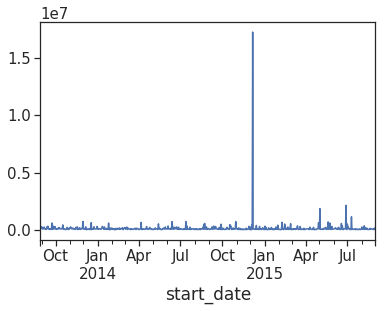

In [53]:
trip.resample('D', on='start_date')['duration'].max().plot()

In [50]:
sf_ana = trip.set_index('start_date')['2014-12-06']

In [52]:
sf_ana[sf_ana['duration'] == sf_ana['duration'].max()]

,id,duration,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,dayofweek
start_date,,,,,,,,,,,
2014-12-06 21:59:00,568474,17270400,South Van Ness at Market,66,2015-06-24 20:18:00,2nd at Folsom,62,535,Customer,95531,5


In [30]:
nyc.resample('D', on='starttime')['tripduration'].mean().sort_values()

starttime
2019-01-31     648.494015
2019-01-14     660.790335
2019-03-07     677.316317
2019-02-27     679.915010
2019-03-05     685.974041
2019-01-29     687.778421
2019-02-28     689.321586
2019-01-28     694.760679
2019-01-22     699.838912
2019-02-26     700.270631
2019-02-25     701.736761
2019-03-06     708.049431
2019-02-12     710.401665
2019-01-21     711.577592
2019-01-25     712.802386
2019-01-30     713.292340
2019-03-08     714.738974
2019-02-07     719.968687
2019-01-15     724.793591
2019-03-13     731.435415
2019-01-23     733.603862
2019-02-20     739.450553
2019-01-16     740.582022
2019-02-19     744.680990
2019-01-17     745.987678
2019-01-12     747.606223
2019-01-24     748.844828
2019-01-19     749.819058
2019-02-06     750.311717
2019-01-07     754.322151
                 ...     
2019-01-13     839.841508
2019-03-18     841.214369
2019-03-25     846.267703
2019-03-02     847.540303
2019-02-23     849.226177
2019-02-01     853.485590
2019-01-06     864.909510
20

In [32]:
nyc = nyc.set_index('starttime')

In [37]:
nyc['2019-03-30'][nyc['2019-03-30']['tripduration'] == nyc['2019-03-30']['tripduration'].max()]

,tripduration,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
starttime,,,,,,,,,,,,,,
2019-03-30 13:37:52.643,822576,2019-04-09 02:07:29.212,344.0,Monroe St & Bedford Ave,40.685144,-73.953809,437.0,Macon St & Nostrand Ave,40.680983,-73.950048,17535,Customer,1969,0


In [60]:
folium_map = folium.Map(location=[40.68, -73.95], zoom_start=15, tiles='CartoDB dark_matter', width = '50%')
folium.CircleMarker(location=(40.685144, -73.953809),
                    radius=5, color='white', popup='Start: Monroe St & Bedford Ave', fill=True).add_to(folium_map)
folium.CircleMarker(location=(40.680983, -73.95004),
                    radius=5, color='white', popup='End: Macon St & Nostrand Ave', fill=True).add_to(folium_map)

In [61]:
folium_map

In [97]:
822576/60/60/24

9.520555555555555